In [11]:
import scanpy as sc
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.utils import algorithm_globals

# Load the AnnData object
fname = 'sce_data.h5ad'
#fname = r'Z:\selim_working_dir\PERCEPTION2_selim_custom\cancer_cell_lines.h5ad'
adata = sc.read_h5ad(fname) 

In [12]:
# Fix this bug on write_h5ad matlab function
# var_names0 = adata.var_names.str.extract(r"\('?(.*?)'?\)", expand=False)
# var_names0 = var_names0.str.replace(",", "", regex=False)  # Remove any commas
# var_names0 = var_names0.str.replace("'", "", regex=False)
# adata.var_names = var_names0
# del var_names0

In [13]:
# Set the random seed for reproducibility
algorithm_globals.random_seed = 42

# Split indices into training and testing
train_indices, test_indices = train_test_split(
    range(adata.shape[0]), train_size=0.8, random_state=algorithm_globals.random_seed
)

# Subset AnnData using the indices
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()

# Verify shapes and content
print(f"Training set shape: {adata_train.shape}")
print(f"Testing set shape: {adata_test.shape}")

Training set shape: (6625, 13493)
Testing set shape: (1657, 13493)


In [14]:
# Normalize and log-transform data
adata_train.layers["counts"] = adata_train.X.copy()
sc.pp.normalize_total(adata_train)
sc.pp.log1p(adata_train)
sc.pp.highly_variable_genes(adata_train, n_top_genes=5000)

In [15]:
# Normalize and log-transform data
adata_test.layers["counts"] = adata_test.X.copy()
sc.pp.normalize_total(adata_test)
sc.pp.log1p(adata_test)
sc.pp.highly_variable_genes(adata_test, n_top_genes=5000)

In [16]:
hvg_train = adata_train.var.index[adata_train.var["highly_variable"]].tolist()
hvg_test = adata_test.var.index[adata_test.var["highly_variable"]].tolist()
overlap = set(hvg_train) & set(hvg_test)  # Intersection
print(f"Number of overlapping HVGs: {len(overlap)}")
print("Example overlapping HVGs:", list(overlap)[:10])  # Show a few examples


Number of overlapping HVGs: 3787
Example overlapping HVGs: ['Cpne5', 'Upp1', 'H2-DMb2', 'Pard6g', 'Ptprcap', 'Rcn3', 'Igfbp4', 'Pik3ip1', 'Cd36', 'Chrnb1']


In [17]:
# Check if 'Nr4a1' exists in hvg_test
gene = 'Nr4a1'
if gene in hvg_test:
    print(f"'{gene}' is in hvg_test!")
else:
    print(f"'{gene}' is NOT in hvg_test.")

# Check if 'Nr4a1' exists in hvg_test
if gene in hvg_train:
    print(f"'{gene}' is in hvg_train!")
else:
    print(f"'{gene}' is NOT in hvg_train.")

'Nr4a1' is in hvg_test!
'Nr4a1' is in hvg_train!


In [18]:
# Ensure overlapping HVGs are marked in adata_train and adata_test
overlap = set(hvg_train) & set(hvg_test)  # Intersection of HVGs

# Update the 'highly_variable' column in adata_train
adata_train.var['highly_variable'] = adata_train.var.index.isin(overlap)

# Update the 'highly_variable' column in adata_test
adata_test.var['highly_variable'] = adata_test.var.index.isin(overlap)

# Verify updates
print("Updated 'highly_variable' in adata_train:")
print(adata_train.var['highly_variable'].value_counts())
print("\nUpdated 'highly_variable' in adata_test:")
print(adata_test.var['highly_variable'].value_counts())


Updated 'highly_variable' in adata_train:
highly_variable
False    9706
True     3787
Name: count, dtype: int64

Updated 'highly_variable' in adata_test:
highly_variable
False    9706
True     3787
Name: count, dtype: int64


Number of overlapping HVGs: 3787
Example overlapping HVGs: ['Cpne5', 'Upp1', 'H2-DMb2', 'Pard6g', 'Ptprcap', 'Rcn3', 'Igfbp4', 'Pik3ip1', 'Cd36', 'Chrnb1']


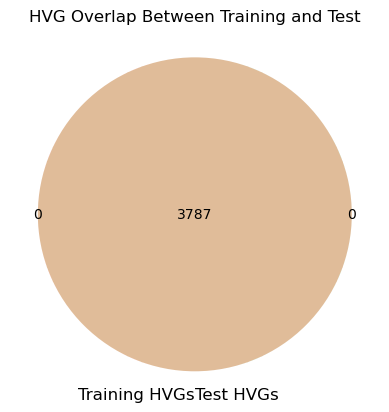

In [19]:
hvg_train = adata_train.var.index[adata_train.var["highly_variable"]].tolist()
hvg_test = adata_test.var.index[adata_test.var["highly_variable"]].tolist()
overlap = set(hvg_train) & set(hvg_test)  # Intersection
print(f"Number of overlapping HVGs: {len(overlap)}")
print("Example overlapping HVGs:", list(overlap)[:10])  # Show a few examples
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

venn2([set(hvg_train), set(hvg_test)], set_labels=("Training HVGs", "Test HVGs"))
plt.title("HVG Overlap Between Training and Test")
plt.show()


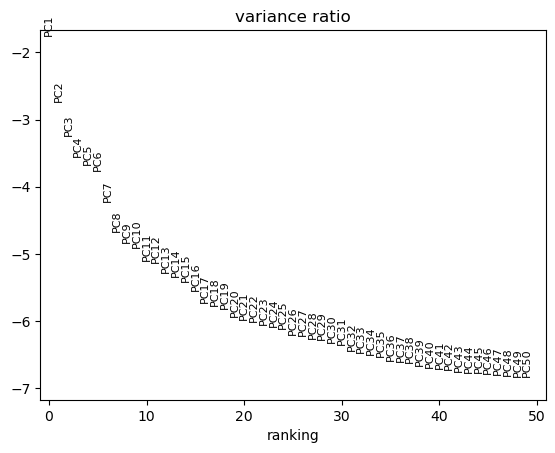

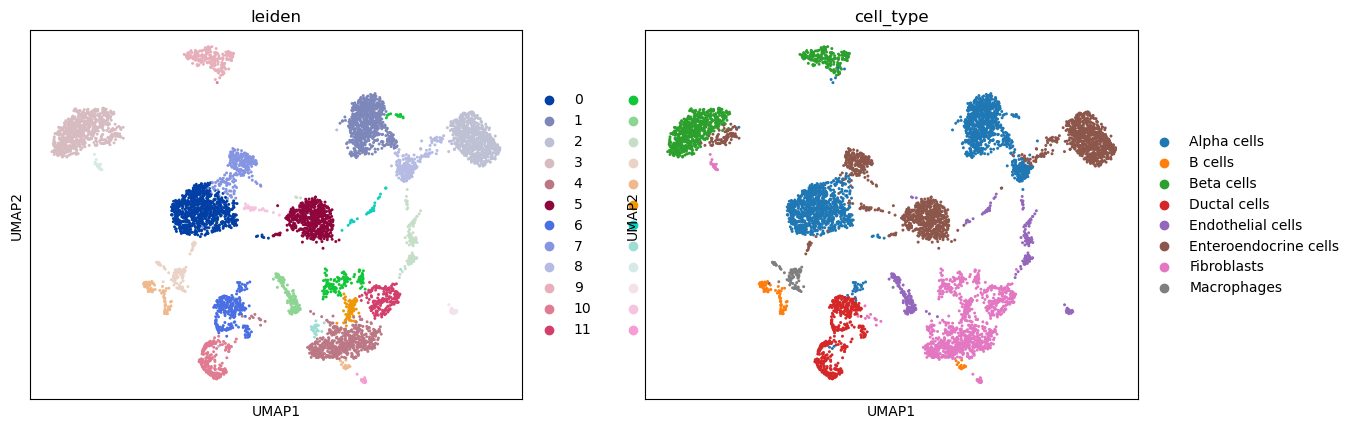

In [20]:
# Analyze training data
# Normalize and log-transform data
#adata_train.X = adata_train.layers["counts"].copy()
#sc.pp.normalize_total(adata_train)
#sc.pp.log1p(adata_train)
npcs = 50
sc.tl.pca(adata_train, n_comps=npcs)
sc.pl.pca_variance_ratio(adata_train, n_pcs=npcs, log=True)
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)
sc.tl.leiden(adata_train, flavor="leidenalg", n_iterations=2)
sc.pl.umap(adata_train, color=["leiden", 'cell_type'])

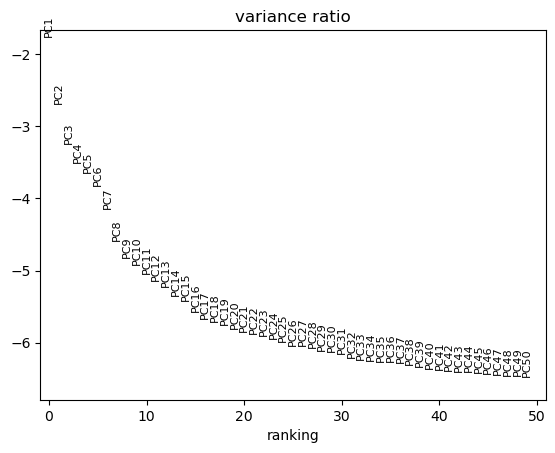

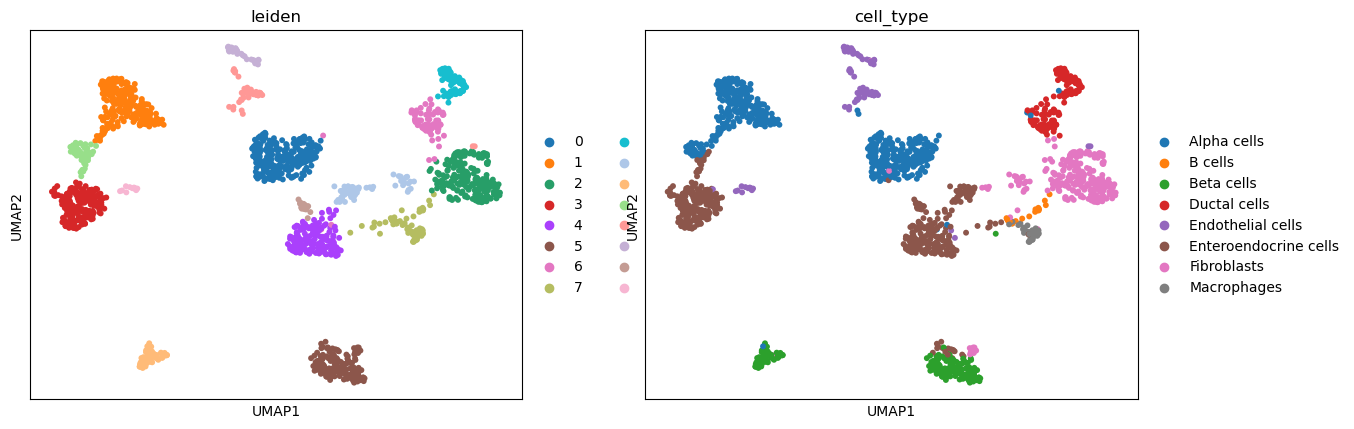

In [21]:

# Analyze testing data
sc.tl.pca(adata_test, n_comps=npcs)
sc.pl.pca_variance_ratio(adata_test, n_pcs=npcs, log=True)
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)
sc.tl.leiden(adata_test, flavor="leidenalg", n_iterations=2)
sc.pl.umap(adata_test, color=["leiden", "cell_type"])

In [22]:
import numpy as np
print(np.min(adata_train.X), np.max(adata_train.X), np.mean(adata_train.X))
print(np.min(adata_test.X), np.max(adata_test.X), np.mean(adata_test.X))


0.0 8.643947039940173 0.1443192062770327
0.0 8.581210052603588 0.1422880094666868


In [33]:
# Classical solver
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

npc_test = 5
train_labels = adata_train.obs['cell_type']
test_labels =  adata_test.obs['cell_type']
Xtrain = adata_train.obsm['X_pca'][:, :npc_test]
Xtest = adata_test.obsm['X_pca'][:, :npc_test]

import numpy as np
print(np.min(Xtrain), np.max(Xtrain), np.mean(Xtest))
print(np.min(Xtest), np.max(Xtest), np.mean(Xtest))

-11.837228 22.098665 1.266194e-09
-11.821839 21.812191 1.266194e-09


In [35]:
import numpy as np
# We need to discretize to separate better the states
# Min-max scaling function with training stats
def minmax_scale_to_pi_train_test(data, train_min, train_max):
    scaled_data = (data - train_min) / (train_max - train_min)  # Scale to [0, 1]
    scaled_data = scaled_data - 0.5
    scaled_data = 1.5 * np.pi * scaled_data # Scale to [-3π/2, 3π/2]
    return scaled_data

# Compute min and max from training data
train_min = np.min(Xtrain, axis=0)
train_max = np.max(Xtrain, axis=0)

# Scale training and test data
Xtrain = minmax_scale_to_pi_train_test(Xtrain, train_min, train_max)
Xtest = minmax_scale_to_pi_train_test(Xtest, train_min, train_max)

# Print to verify the range
print("Xtrain range:", np.min(Xtrain), "to", np.max(Xtrain))
print("Xtest range:", np.min(Xtest), "to", np.max(Xtest))

Xtrain range: -2.3561945 to 2.3561945
Xtest range: -2.4051886 to 2.655956


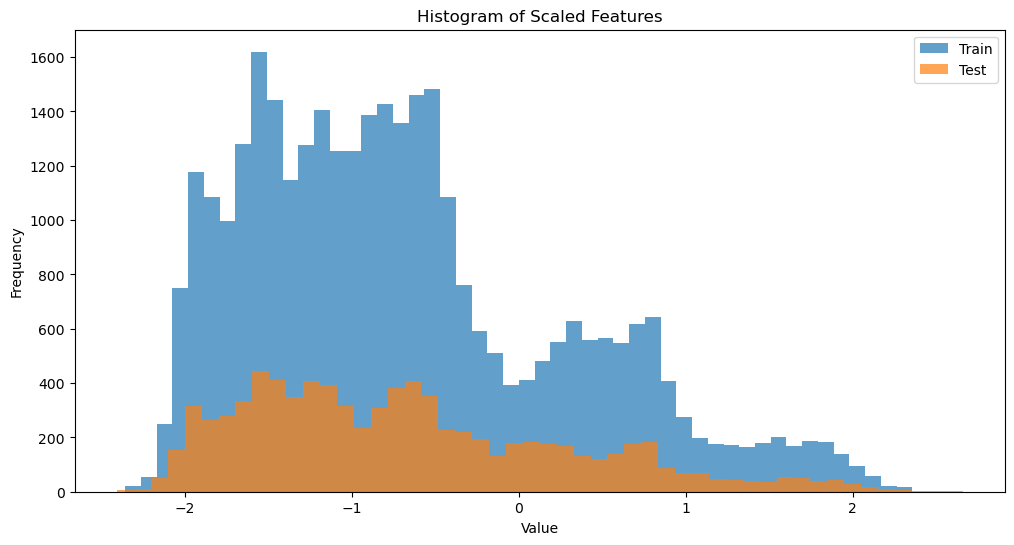

In [36]:
import matplotlib.pyplot as plt

plt.hist(Xtrain.flatten(), bins=50, alpha=0.7, label='Train')
plt.hist(Xtest.flatten(), bins=50, alpha=0.7, label='Test')
plt.title("Histogram of Scaled Features")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [37]:
svc = SVC()
_ = svc.fit(Xtrain, train_labels)  # suppress printing the return value
train_score_c4 = svc.score(Xtrain, train_labels)
test_score_c4 = svc.score(Xtest, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.96
Classical SVC on the test dataset:     0.94


5
1


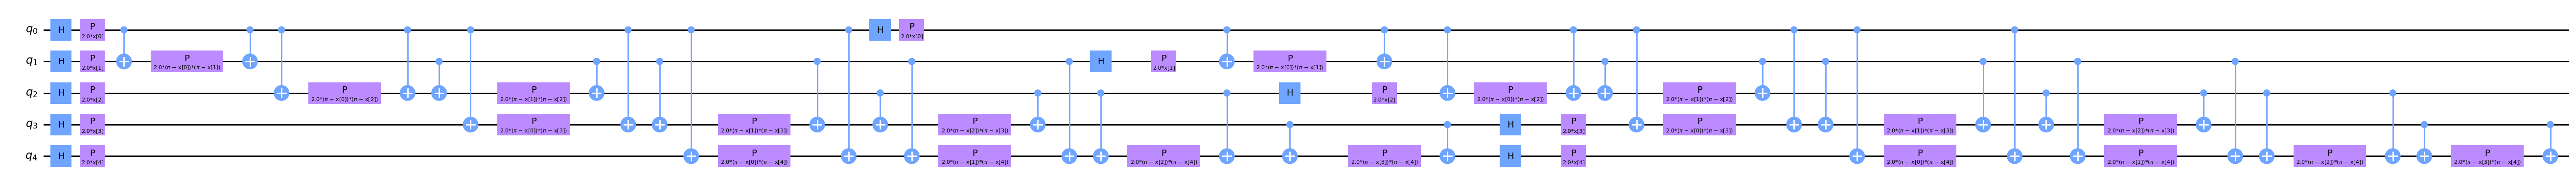

In [38]:
from qiskit.circuit.library import ZZFeatureMap

num_features = Xtrain.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
print(feature_map.num_qubits)  # Should match num_features
print(feature_map.depth())     # Check depth for debugging

feature_map.decompose().draw(output="mpl", style="clifford", fold=1)

In [39]:
# Define ansatz
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=num_features, reps=2)

#from qiskit.circuit.library import EfficientSU2
#ansatz = EfficientSU2(num_qubits=num_features, reps=3)

#from qiskit.circuit.library import QAOAAnsatz
#ansatz = QAOAAnsatz(num_qubits=num_features, reps=2)

In [40]:
from qiskit_machine_learning.optimizers import COBYLA
optimizer = COBYLA(maxiter=300, tol=1e-4)

#from qiskit_machine_learning.optimizers import SPSA
#optimizer = SPSA(maxiter=100, learning_rate=0.01, perturbation=0.1)

from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()


In [41]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
from matplotlib.ticker import ScalarFormatter

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    from IPython.display import clear_output
    
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)

    plt.figure(figsize=(12, 6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    # Plot the objective function values
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    
    # Format the y-axis to show floating-point numbers
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.ticklabel_format(useOffset=False)
    
    plt.show()


In [42]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


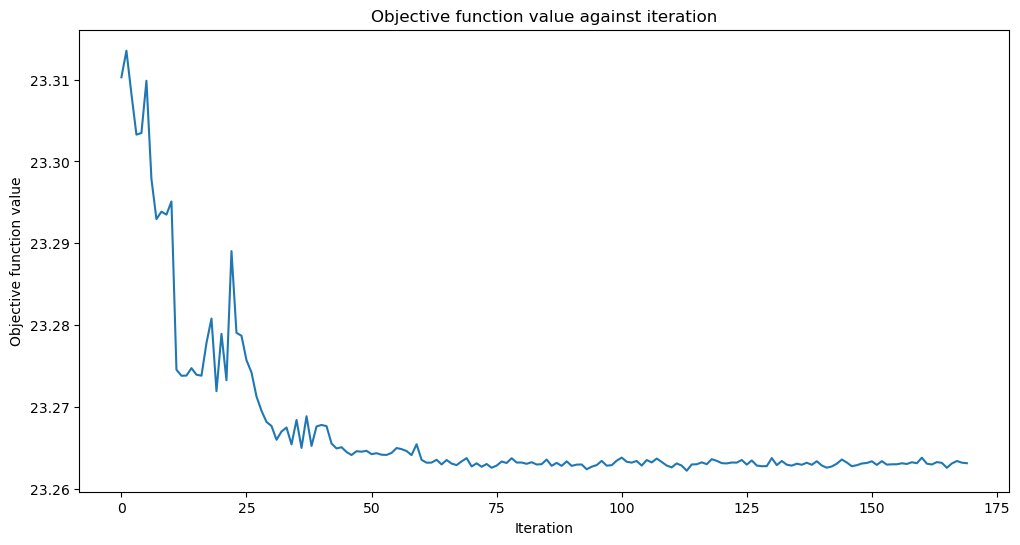

Training time: 6935 seconds
Train score: 0.20724528301886794
Test score: 0.21907060953530477


In [43]:
import numpy as np


# Convert train and test labels to NumPy arrays
train_labels = np.array(adata_train.obs['cell_type'])
test_labels = np.array(adata_test.obs['cell_type'])

# Load the model
#vqc = VQC.load("vqc_checkpoint.model")
#vqc.warm_start = True  # Allow training continuation

start = time.time()
vqc.fit(Xtrain, train_labels)
elapsed = time.time() - start

#vqc.save("vqc_checkpoint.model")

print(f"Training time: {round(elapsed)} seconds")

# Final evaluation (optional)
train_score = vqc.score(Xtrain, train_labels)
print("Train score:", train_score)

test_score = vqc.score(Xtest, test_labels)
print("Test score:", test_score)
